# InitialsGAN
```GAN 04 - Adjustable GAN with UI ```

* Used PR Castro's code for reference: https://github.com/prcastro/pytorch-gan
* Used Yun Chen's code for reference: https://github.com/chenyuntc/pytorch-GAN

In [1]:
import UI
UI.Show()

### Set model parameters:

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

\* Only relevant in case of use of Wasserstein distance.

In [2]:
UI.PrintModelSettings()

#### Please check your settings:

ConvolutionalGAN, BCE loss, Adam optimizer, BatchNorm, batchsize of 32, learning rate of 0.0005, beta1 of 0.5, for 25 epochs.


#### Results to be saved at:

Z:/GAN-Training-Results/WConvolutional_64x64_32bs/


In [3]:
UI.showrunmodelbutton()

A Jupyter Widget

* Runs all the cells below


### Importing libraries and dataset

In [16]:
# import the dataset class (64x64 images)
import dataset02 as dataset

# python imports
import itertools
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

# pytorch imports
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import RMSprop

### Retrieve parameters

In [17]:
# Get the settings from the buttons above
loss = UI.loss.value
optimization = UI.optim.value
normalization = UI.norm.value
batchsize = int(UI.batch.value)
num_epochs = UI.epochs.value
lr = UI.lrate.value # learning rate
beta1 = UI.beta1.value 
clamp_num = UI.clamp.value # WGAN clip gradient

# Save path for results
savepath = UI.savepath.value

In [18]:
# This opens the HDF5 database and allows us to query it
data = dataset.get_dataset()
print("there are", len(data), "images in this dataset")

there are 30650 images in this dataset


### Creating a dataloader 

In [19]:
# Setting threads (num_workers) to 0 as suggested at https://discuss.pytorch.org/t/dataloader-iteration-hang-up/12886/3
threads = 0 # can increase this to have more data preloading, useful if your CPU cant keep up with GPU
shuffle = True # Shuffles the dataset before loading batches
cuda = True

train_loader = DataLoader(dataset=data, num_workers=threads, batch_size=batchsize, shuffle=shuffle, pin_memory=cuda)

### Other parameters

In [20]:
# 'Hardcoded' for the initials dataset
noisedim = 100 # noise dimension
image_size = 64
image_size2 = 64
nc = 1 # channel of img 
ngf = 64 # generate channel
ndf = 64 # discriminative channel

# Show the number of batches
num_batches = len(train_loader)
print('There are ' + str(num_batches) + ' batches')

There are 479 batches


### Model set-up

In [21]:
# Conditionally set the normalization
if(normalization == 'BatchNorm'):
    gnormlayer0 = nn.BatchNorm2d(ngf)
    gnormlayer1 = nn.BatchNorm2d(ngf*2)
    gnormlayer2 = nn.BatchNorm2d(ngf*4)
    gnormlayer3 = nn.BatchNorm2d(ngf*8)
    
    dnormlayer0 = nn.BatchNorm2d(ndf)
    dnormlayer1 = nn.BatchNorm2d(ndf*2)
    dnormlayer2 = nn.BatchNorm2d(ndf*4)
    dnormlayer3 = nn.BatchNorm2d(ndf*8)
elif(normalization == 'InstanceNorm'):
    gnormlayer0 = nn.InstanceNorm2d(ngf)
    gnormlayer1 = nn.InstanceNorm2d(ngf*2)
    gnormlayer2 = nn.InstanceNorm2d(ngf*4)
    gnormlayer3 = nn.InstanceNorm2d(ngf*8)
    
    dnormlayer0 = nn.InstanceNorm2d(ndf)
    dnormlayer1 = nn.InstanceNorm2d(ndf*2)
    dnormlayer2 = nn.InstanceNorm2d(ndf*4)
    dnormlayer3 = nn.InstanceNorm2d(ndf*8)
else: 
    raise ValueError('The currently set normalization option (\'' + normalization + '\') cannot be used.')

In [22]:
# Conditionally set up the final layer of discriminator net
if(loss == 'Wasserstein'):
    discriminator = nn.Sequential(
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        dnormlayer1,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        dnormlayer2,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        dnormlayer3,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        # For WGAN we remove the sigmoid function
        # nn.Sigmoid()
    ).cuda()
else:
    discriminator = nn.Sequential(
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        dnormlayer1,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        dnormlayer2,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        dnormlayer3,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        nn.Sigmoid()
    ).cuda()

In [23]:
generator= nn.Sequential(
        nn.ConvTranspose2d(noisedim,ngf*8,4,1,0,bias=False),
        gnormlayer3,
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
        gnormlayer2,
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        gnormlayer1,
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        gnormlayer0,
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
        nn.Tanh()
    ).cuda()

### Weigth initialization

In [25]:
if(loss == 'Wasserstein'):
    def weight_init(m):
        class_name=m.__class__.__name__
        if class_name.find('Conv')!=-1:
            m.weight.data.normal_(0,0.02)
        elif class_name.find('Norm')!=-1:
            m.weight.data.normal_(1.0,0.02)

    discriminator.apply(weight_init)
    generator.apply(weight_init)

### Criterion

In [26]:
if(loss == 'BCE'):
    criterion = nn.BCELoss()

### Optimizer

In [27]:
if(optimization == 'Adam'):
    d_optimizer = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(beta1,0.999))
    g_optimizer = torch.optim.Adam(generator.parameters(),lr=lr,betas=(beta1,0.999))
elif(optimization == 'RMSprop'):
    d_optimizer = RMSprop(discriminator.parameters(), lr=lr)
    g_optimizer = RMSprop(generator.parameters(), lr=lr)
else:
    raise ValueError('The currently set optimization option (\'' + optimization + '\') cannot be used.')

### Training

In [28]:
# Necessary for training
if(loss == 'Wasserstein'):
    one = torch.FloatTensor([1])
    mone = -1*one
    one = one.cuda()
    mone = mone.cuda()

In [29]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    if(loss == 'BCE'):
        real_loss = criterion(outputs, real_labels)
        real_score = outputs
    elif(loss == 'Wasserstein'):
        outputs.backward(one)
    
    outputs = discriminator(fake_images)
    if(loss == 'BCE'):
        fake_loss = criterion(outputs, fake_labels)
        fake_score = outputs
        d_loss = real_loss + fake_loss
        d_loss.backward()
    elif(loss == 'Wasserstein'):
        outputs.backward(mone)
    
    d_optimizer.step()

In [30]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    if(loss == 'BCE'):
        g_loss = criterion(discriminator_outputs, real_labels)
        g_loss.backward()
    elif(loss == 'Wasserstein'):
        discriminator_outputs.backward(one)
    g_optimizer.step()

In [31]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 25
fix_noise = Variable(torch.FloatTensor(num_test_samples, noisedim, 1, 1).normal_(0,1)).cuda()

### Execute training and sampling

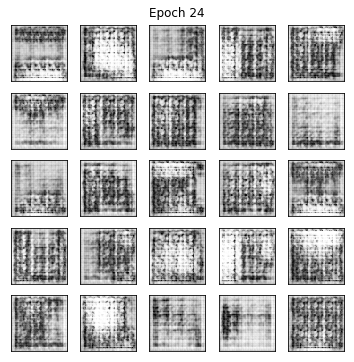

Epoch [25/25], Step[380/479]


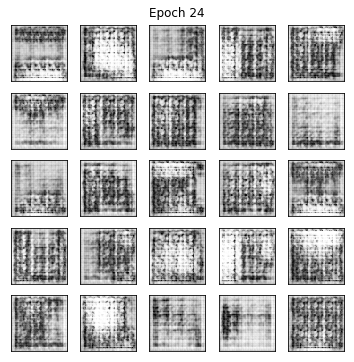

In [32]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Save the model settings to the save location
f = open(savepath + "modelsettings.txt","w+")
f.write(UI.GetFormattedSettings())
f.close()

for epoch in range(num_epochs):
    print('Working on epoch ' + str(epoch) + ' ...')
    for n, (images, letters, countries, cities, names) in enumerate(train_loader):
        images = Variable(images).cuda()
        real_labels = Variable(torch.ones(images.size(0)).cuda())
        
        # Generate the noise
        noise = torch.randn(images.size(0),noisedim,1,1)
        noise = Variable(noise).cuda()
        
        # clip paramaters for discriminator (only for wasserstein)
        if(loss == 'Wasserstein'):
            for parameter in discriminator.parameters():
                parameter.data.clamp_(-clamp_num, clamp_num)
        
        # Sample from generator using the noise
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        
        # Train the discriminator
        train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = torch.randn(images.size(0),noisedim,1,1)
        noise = Variable(noise).cuda()
        
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        
        # Train the generator more often for wasserstein
        if (loss == 'Wasserstein'):
            if (n+1)%5 == 0:
                train_generator(generator, outputs, real_labels)
                if n%100: pass
        elif (loss == 'BCE'):
            train_generator(generator, outputs, real_labels)
        
        # For every hundred batches show and save a plot of output
        if (n+1) % 190 == 0:
            step = 0
            test_images = generator(fix_noise)
            
            for k in range(num_test_samples):
                i = k//5
                j = k%5
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(64, 64), cmap='gray')
            display.clear_output(wait=True)
            plt.title("Epoch " + str(epoch), y=5.85, x=-1.98)
            display.display(plt.gcf())
            
            plt.savefig(savepath + 'result_' + str(epoch+1) + '-' + str(n+1) + '.png')
            step += 1
            
            print('Epoch [%d/%d], Step[%d/%d]' 
                  %(epoch + 1, num_epochs, n+1, num_batches))